## Install the package dependencies before running this notebook

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

In [22]:
device = None
if torch.cuda.is_available():
    device = torch.device('cuda')

## Create a Torch.Dataset class for the training dataset

In [23]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):

    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs = []
        self.outputs = []

        for city_name in cities:
            city_inputs, city_outputs = get_city_trajectories(city=city_name, split=split, normalized=False)
            for i in range(len(city_inputs)):
                self.inputs.append(city_inputs[i])
                self.outputs.append(city_outputs[i])
        # self.inputs.to(device)
        # self.outputs.to(device)
        # print(len(self.inputs), len(self.outputs))

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
train_dataset  = ArgoverseDataset(split = 'train')

In [24]:
val_dataset = ArgoverseDataset(split = 'val')

In [25]:
len(val_dataset)

40765

## Create a DataLoader class for training

In [26]:
batch_sz = 4  # batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_sz)

In [27]:
from torch import nn, optim

class Pred(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 120),
            nn.ReLU(),
            nn.Linear(120, 120)
        )
        
    def forward(self, x):
        x = x.reshape(-1, 100).float()
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.reshape(-1, 60, 2)
        return x

### Define LSTM Model

In [141]:
class LSTM(torch.nn.Module):
    
    def __init__(self, input_size, output_size, num_hidden=120, num_layers=4, drop=0.2):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_size
        self.output_size = output_size
        self.num_hidden = num_hidden

        self.lstm = torch.nn.LSTM(
            input_size = input_size*2,
            hidden_size = num_hidden, 
            num_layers = num_layers, 
            batch_first = True,
            dropout = drop)

        self.classifier = nn.Linear(num_hidden, output_size*2)

        self.h  = torch.rand(self.num_layers, output_size*2, self.num_hidden)
        self.c = torch.rand(self.num_layers, output_size*2, self.num_hidden)
        
    def forward(self, x):
        x = x.reshape(-1, 100).float()
        self.lstm.flatten_parameters()
        # print("x shape:", x.shape)
        out, (self.h, self.c) = self.lstm(x, (self.h, self.c))
        out = self.classifier(self.h)
        out = out.reshape(-1, self.output_size, 2)
        return out



class LSTM(torch.nn.Module):
    def __init__(self, num_hidden, num_layers, input_size, seq_len, batch_size, device):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_size
        self.seq_len = seq_len
        self.device = device
        self.num_hidden = num_hidden
        self.proj_size = 2
        self.batch_size = batch_size
        
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=num_hidden, num_layers=num_layers, batch_first=True, device=device)

        self.relu = torch.nn.ReLU()
        self.linear = torch.nn.Linear(in_features = num_hidden, out_features = 100, device=device)
        self.h  = torch.rand(self.num_layers, batch_size, self.num_hidden, device=device)
        self.c = torch.rand(self.num_layers, batch_size, self.num_hidden, device=device)
    
    def forward(self,x):
        # Propagate input through LSTM
        h  = torch.rand(self.num_layers, self.batch_size, self.num_hidden, device=device)
        c = torch.rand(self.num_layers, self.batch_size, self.num_hidden, device=device)
        #h2  = torch.rand(self.num_layers, self.batch_size, self.num_hidden, device=device)
        #c2 = torch.rand(self.num_layers, self.batch_size, self.num_hidden, device=device)
        output, (h, c) = self.lstm(x, (h, c)) #lstm with input, hidden, and internal state
        #output, (h,c) = self.lstm2(h, (h2,c2))
        output = self.linear(h)
        output = torch.reshape(output, (self.batch_size, self.seq_len, self.input_size))
#         hn = hn.view(-1, self.num_hidden) #reshaping the data for Dense layer next
      #  //out = self.relu(hn) 
     #   //out = self.relu(out) #relu
    #out = self.fc(out) #Final Output
        return output

In [142]:
pred = LSTM(50, 60).to(device)
opt = optim.Adam(pred.parameters(), lr=1e-3)

In [144]:
for epoch in range(10):
    
    total_loss = 0
    for i_batch, sample_batch in enumerate(train_loader):
        inp, out = sample_batch
        inp = inp.to(device)
        out = out.to(device)
        preds = pred(inp)
        # print("preds shape:", preds.shape)

        loss = ((preds - out) ** 2).sum()
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        total_loss += loss.item()
        
    print('epoch {} loss: {}'.format(epoch, total_loss / len(train_dataset)))

RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors

In [ ]:
val_loader = DataLoader(val_dataset,batch_size=batch_sz)

val_loss = 0
for i_batch, sample_batch in enumerate(val_loader):
    inp, out = sample_batch
    preds = pred(inp)
    loss = ((preds - out) ** 2).sum()

    val_loss += loss.item()
print('loss: {}'.format(val_loss / len(val_dataset)))

KeyboardInterrupt: 

## Sample a batch of data and visualize 

torch.Size([4, 50, 2]) torch.Size([4, 60, 2])


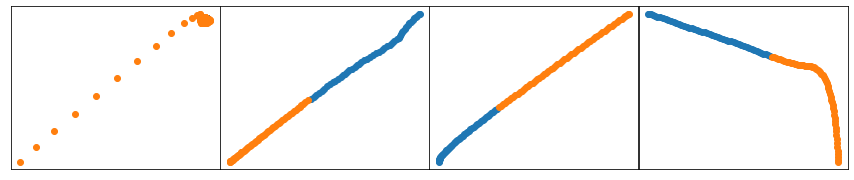

In [ ]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])

        
for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    print(inp.shape, out.shape)
    
    """
    TODO:
      implement your Deep learning model
      implement training routine
    """
    show_sample_batch(sample_batch)
    break

In [ ]:
all_preds = []
for city in cities:
    test_input, _ = get_city_trajectories(city, 'test')
    # print(city, "shape:", test_input.shape)
    for x in range(len(test_input)):
        traj = pred(torch.tensor(test_input[x]))
        # print(city, "shape:", traj.shape)
        # print(traj)
        all_preds.append(traj)
print(len(all_preds))
print(all_preds)

29843


KeyboardInterrupt: 

In [ ]:
import pandas as pd

def predictions_to_csv():
    num_pred_steps = 60
    all_preds = np.zeros(shape=(0, num_pred_steps * 2))
    city_col = np.array([])

    for city_name in cities:

        print("Processing city", city_name)
        # Get Training input values
        test_traj_in, test_traj_out = get_city_trajectories(city=city_name, split="test")
        print(test_traj_in.shape)

        # REPLACE. get predictions for this city
        test_pred_arr = []
        for x in range(len(test_traj_in)):
            # print("input shape", test_traj_in[x].shape)
            traj = pred(torch.tensor(test_traj_in[x]))[0]
            # print("output shape", traj.shape)
            add = traj.detach().numpy()
            # print(add)
            test_pred_arr.append(add)
        test_pred_arr = numpy.array(test_pred_arr)
        print(test_pred_arr.shape)
    
        # Reshape the predictions to the submission format size (120)
        test_pred_arr_reshaped = np.reshape(test_pred_arr, newshape=(test_traj_in.shape[0], num_pred_steps * 2))
        print(test_pred_arr_reshaped.shape)

        # Add to total predictions / columns
        all_preds = np.r_[all_preds, test_pred_arr_reshaped]
        city_col = np.r_[city_col, [str(i) + "_" + city_name for i in range(test_pred_arr.shape[0])]]
    
    # Convert predictions to csv file
    sub_df = pd.DataFrame(np.c_[city_col, all_preds], columns=[np.r_[["ID"], ["v" + str(i) for i in range(120)]]])
    sub_df.to_csv('predictions_submission.csv', index=None)


predictions_to_csv()

Processing city austin
(6325, 50, 2)
(6325, 60, 2)
(6325, 120)
Processing city miami
(7971, 50, 2)
(7971, 60, 2)
(7971, 120)
Processing city pittsburgh
(6361, 50, 2)
(6361, 60, 2)
(6361, 120)
Processing city dearborn
(3671, 50, 2)
(3671, 60, 2)
(3671, 120)
Processing city washington-dc
(3829, 50, 2)
(3829, 60, 2)
(3829, 120)
Processing city palo-alto
(1686, 50, 2)
(1686, 60, 2)
(1686, 120)
